In [6]:
# EXAMPLE MAKE ONE_TO_ONE_PEAKS THEN SAVE IT
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

both_df = pd.read_csv("/home/azstephe/liverRegression/regression_liver/data/splits/macaqueMouse/macaqueToMouse_liver_macaqueEnhancer_mouseEnhancer_val_wawb.narrowPeak", sep="\t", header=None)
mac_qn = pd.read_csv("/home/azstephe/liverRegression/regression_liver/data/ladder_qn/macaque_liver_pos_ALL.bed", sep="\t", header=None)
mouse_qn = pd.read_csv("/home/azstephe/liverRegression/regression_liver/data/ladder_qn/mouse_liver_pos_ALL.bed", sep="\t", header=None)

unique1_2 = both_df[~both_df.duplicated(subset=[1, 2], keep=False)] # entries with unique mac mapped to mouse start and end
all_unique = unique1_2[~unique1_2.duplicated(subset=[11,12], keep=False)]

#### FUNCTIONS

def pearson_spearman(x, y):
    pearson_corr, pearson_p_value = scipy.stats.pearsonr(x, y)
    print(f"Pearson correlation coefficient: {pearson_corr:.4f}, p-value: {pearson_p_value:.4g}")

    spearman_corr, spearman_p_value = scipy.stats.spearmanr(x, y)
    print(f"Spearman correlation coefficient: {spearman_corr:.4f}, p-value: {spearman_p_value:.4g}")
    
def collapse_if_identical(lst):
    return lst[0] if all(x == lst[0] for x in lst) else lst
    

# takes in list and returns peak with largest signal
def keep_largest_signal(lst, qn_df):
    if isinstance(lst, list):
        maxPeakName = ''
        maxPeakStrength = 0
        for peak in lst:
            matching_rows = qn_df[qn_df[3] == peak]
            if not matching_rows.empty:
                signal = matching_rows[4].iloc[0]
                if signal > maxPeakStrength:
                    maxPeakStrength = signal
                    maxPeakName = peak
        return maxPeakName
    else: 
        return lst

# def overlap(start1, end1, start2, end2):
#     return max(0, min(end1, end2)-max(start1, start2))

def get_biggest_overlap(lst, col, df):
    maxOverlap = 0
    maxPeakOverlap = ""
    for peak in lst:
        row = df[df[col] == peak].iloc[0] #iloc bc possible to return multiple rows (never will based on th
        overlap = max(0, min(row[2], row[12])-max(row[1], row[11]))
        if overlap > maxOverlap:
            maxOverlap = overlap
            maxPeakOverlap = peak
    return peak

#### COL1,2 DUPLICATES

duplicates3 = both_df[both_df.duplicated(subset=[1, 2], keep=False)] # entries with duplicated mac mapped to mouse start and end 
grouped_dups3 = duplicates3.groupby([1, 2])[3].apply(list).reset_index(name='col3')

# grouped dups: start | end | [peaks with these endpoints]
grouped_dups3['col3'] = grouped_dups3['col3'].apply(collapse_if_identical) 

grouped_dups3['col3'] = grouped_dups3['col3'].apply(lambda x: keep_largest_signal(x, mac_qn)) # redundant endpoints now map to 1 peak in col3
grouped_dups3 = grouped_dups3[grouped_dups3['col3'] != ''] # remove macaque peaks that aren't large enough

# df of duplicated col1,2 with strongest peak
keep_strongestcol3 = duplicates3.merge(grouped_dups3[['col3']], left_on=3, right_on='col3', how='inner').drop('col3', axis=1) # keeps the strongest signal in col3 for redundant endpoints

#### COL11,12 DUPLICATES

grouped_dups13 = keep_strongestcol3.groupby([11, 12])[13].apply(list).reset_index(name='col13')
grouped_dups13['col13'] = grouped_dups13['col13'].apply(collapse_if_identical)

grouped_dups13['col13'] = grouped_dups13['col13'].apply(lambda x: keep_largest_signal(x, mouse_qn))
grouped_dups13 = grouped_dups13[grouped_dups13['col13'] != '']

keep_strongestcol13 = keep_strongestcol3.merge(grouped_dups13[['col13']], left_on=13, right_on='col13', how='inner').drop('col13', axis=1)

unique_endpoints = keep_strongestcol13 #rows with unique endpoints from the duplicated endpoints set

####

# col3 peakname duplicates with different endpoints
still_dups_col3 = unique_endpoints[unique_endpoints.duplicated(subset=[3], keep=False)]

# col3peaks | [col13 peaks intersecting col3 peak]
grouped_dcol3 = still_dups_col3.groupby(3)[13].apply(list).reset_index(name='col13')

# get the col13 peak with most overlap of col3
grouped_dcol3['col13'] = grouped_dcol3['col13'].apply(lambda x: get_biggest_overlap(x, 13, still_dups_col3))

merged3 = still_dups_col3.merge(grouped_dcol3[[3, 'col13']], left_on=[3, 13], right_on=[3, 'col13'], how='left', indicator=True)

remove3 = merged3[merged3['_merge'] == 'left_only'].drop(columns=['_merge']) # col13 is what we want to remove

unique_endpoints_subset = unique_endpoints.iloc[:,:20]
remove3_subset = remove3.iloc[:,:20]

# all col3 entries unique
unique3 = unique_endpoints[~unique_endpoints_subset.apply(tuple, axis=1).isin(remove3_subset.apply(tuple, axis=1))] 

####

# col13 peakname duplicates with different endpoints
still_dups_col13 = unique3[unique3.duplicated(subset=[13], keep=False)]

# col13peaks | [col3 peaks intersecting col13 peak]
grouped_dcol13 = still_dups_col13.groupby(13)[3].apply(list).reset_index(name='col3')

# get the col3 peak with most overlap of col13
grouped_dcol13['col3'] = grouped_dcol13['col3'].apply(lambda x: get_biggest_overlap(x, 3, still_dups_col13))

merged13 = still_dups_col13.merge(grouped_dcol13[[13, 'col3']], left_on=[3, 13], right_on=['col3', 13], how='left', indicator=True)

remove13 = merged13[merged13['_merge'] == 'left_only'].drop(columns=['_merge'])

unique3_subset = unique3.iloc[:, :20]
remove13_subset = remove13.iloc[:, :20]

# Identify rows in u3 that are NOT in remove3
filtered_peaks_unique = unique3[~unique3_subset.apply(tuple, axis=1).isin(remove13_subset.apply(tuple, axis=1))]

full_unique = pd.concat([all_unique, filtered_peaks_unique])

# Sort by column '1'
one_to_one_peaks = full_unique.sort_values(by=1).reset_index(drop=True)
one_to_one_peaks.to_csv('/home/azstephe/liverRegression/regression_liver/data/splits/oneToOnePeaks/macaque_mouse.bed', header=None, sep='\t')
one_to_one_peaks
##############################



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,chr9,6668262,6668828,peak24458,-1,.,-1,-1,-1,370,chr9,6668246,6669123,peak20464,1000,.,10.41801,106.98440,104.00175,372
1,chr9,7603389,7603594,peak64793,-1,.,-1,-1,-1,114,chr9,7603184,7603794,peak20478,1000,.,18.10567,247.44370,243.99432,315
2,chr9,7914492,7914988,peak729,-1,.,-1,-1,-1,141,chr9,7914173,7914971,peak20484,1000,.,15.21739,160.17427,156.98676,531
3,chr8,8733638,8734157,peak30058,-1,.,-1,-1,-1,379,chr8,8733751,8734148,peak19418,1000,.,12.36603,110.58308,107.58508,270
4,chr8,8992445,8993220,peak5261,-1,.,-1,-1,-1,506,chr8,8992509,8993074,peak19424,1000,.,6.54450,48.63282,45.97403,451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,chr8,126824543,126825031,peak57495,-1,.,-1,-1,-1,266,chr8,126824525,126825188,peak20431,1000,.,6.61796,38.65833,36.08059,314
256,chr8,126838305,126839235,peak50766,-1,.,-1,-1,-1,182,chr8,126839044,126839256,peak20435,829,.,5.00771,21.68738,19.29232,109
257,chr8,126849473,126850187,peak58047,-1,.,-1,-1,-1,560,chr8,126849637,126850309,peak20437,836,.,4.81874,20.20660,17.83258,402
258,chr8,126920866,126921347,peak14712,-1,.,-1,-1,-1,189,chr8,126920865,126921188,peak20441,1000,.,6.42499,33.74764,31.21361,172


296
149


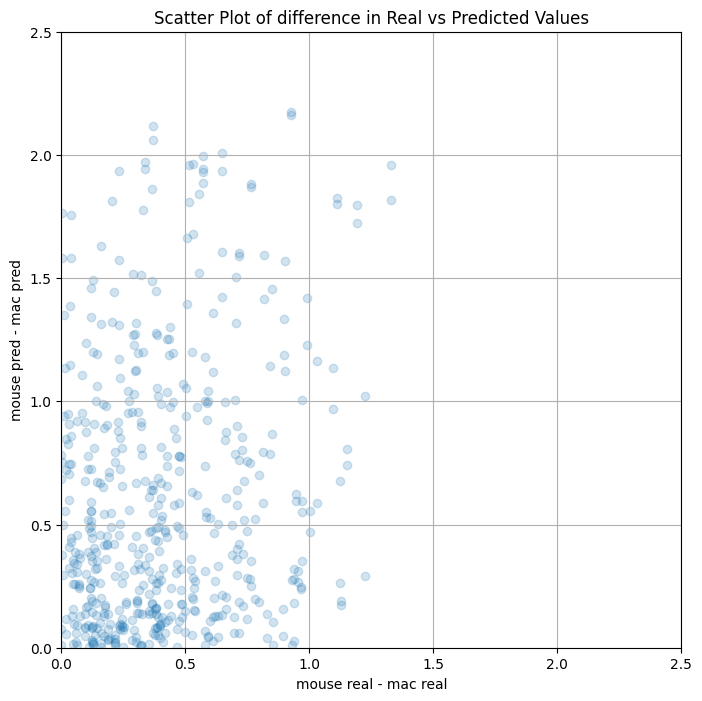

Pearson correlation coefficient: 0.1873, p-value: 1.712e-05
Spearman correlation coefficient: 0.1447, p-value: 0.0009396


In [7]:
pred_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/model_outputs/mcf297qb/activations_macaque_VAL.csv', header=None)
val1_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/val1/macaque_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val2_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/val2/macaque_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val3_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/val3/macaque_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]

val2_df = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/val2/macaque_liver_VAL.narrowPeak', header=None, sep="\t").rename(columns={0: 'mac_chr'})

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)

####################### make the ____ doubled predicted and true df
peaks = one_to_one_peaks[[3, 13]]

merged_df = peaks.merge(mac_qn, how='left', left_on=3, right_on=3, suffixes=('', '_mac'))

# Merge the result with df3 on col13 and df3['col3']
merged_df = merged_df.merge(mouse_qn, how='left', left_on=13, right_on=3, suffixes=('_mac', '_mouse'))

# Subtract col4 values from df2 and df3
merged_df['result'] = merged_df['4_mac'] - merged_df['4_mouse']
res = merged_df[['3_mac', 13, '4_mac', '4_mouse', 'result']]
nan = res[res.isna().any(axis=1)]

####################### 

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len].reset_index(drop=True)

doubled_combined = pd.concat([doubled_val2_df, pred_val2_df], axis=1)

mac_val2_real_pred = doubled_combined.rename(columns={4: 'mac_true', 0:'mac_pred'})

merged_mac_real_pred = peaks.merge(mac_val2_real_pred, how='left', left_on=3, right_on=3).drop(13, axis=1)
m_mac_pred = merged_mac_real_pred[~merged_mac_real_pred[3].isin(nan['3_mac'])].reset_index(drop=True)
m_mac_pred = m_mac_pred.rename(columns={'true':'mac_true', 'pred':'mac_pred', 3:'mac_peak'})

####################### make the mouse doubled predicted and true df

mouse_pred = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/model_outputs/ylfry2wl/activations_mouse_VAL_TRAIN_batch.csv', sep="\t", header=None)
mouse_pred_pos = mouse_pred[:3760]
mouse_pred_neg = mouse_pred[3760:]
mouse_real_pos = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/sorted_log_20615/splits/mousePos/mouse_liver_VAL.narrowPeak', sep="\t", header=None)
mouse_real_neg = pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/negatives/nonMouse_liver_andRat_andCow_andPig_andMacaque_VAL_500bp.bed', sep="\t", header=None)
doubled_mouse_real_pos = pd.concat([mouse_real_pos, mouse_real_pos]).sort_index(kind='mergesort').reset_index(drop=True)
doubled_mouse_real_neg = pd.concat([mouse_real_neg, mouse_real_neg]).sort_index(kind='mergesort').reset_index(drop=True)
doubled_real = pd.concat([mouse_real_pos, mouse_real_neg], axis=1)

doubled_mouse_real_pos = doubled_mouse_real_pos.rename(columns={0:'mouse_chr'})
mouse_pos_real_pred = pd.concat([doubled_mouse_real_pos.drop(columns=5), mouse_pred_pos], axis=1)
mouse_pos_real_pred = mouse_pos_real_pred.rename(columns={4:'mouse_true', 0:'mouse_pred'}).reset_index(drop=True)

merged_mouse_pred = peaks.merge(mouse_pos_real_pred, how='left', left_on=13, right_on=3)

m_mouse_pred = merged_mouse_pred[~merged_mouse_pred[13].isin(nan[13])].reset_index(drop=True)
m_mouse_pred = m_mouse_pred.rename(columns={'real':'mouse_true', 'pred':'mouse_pred', 13:'mouse_peak'}).drop(['3_y'], axis=1)

######################### combine doubled predicted and true df mouse + ____
bigboss = pd.concat([m_mouse_pred, m_mac_pred], axis=1)

bigboss['true'] = bigboss['mouse_true']-bigboss['mac_true']
bigboss['pred'] = bigboss['mouse_pred']-bigboss['mac_pred']



mouse_av = (bigboss.loc[::2, 'mouse_pred'].values + bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (bigboss.loc[::2, 'mac_pred'].values + bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
bigboss['avg_pred'] = bigboss['mouse_pred_avg']-bigboss['mac_pred_avg']
bigboss


same_sign = np.sign(bigboss['true']) == np.sign(bigboss['pred'])
print(same_sign.sum())

same_sign = np.sign(bigboss.loc[::2]['true']) == np.sign(bigboss.loc[::2]['avg_pred'])
print(same_sign.sum())

x = abs(bigboss['true'])
y = abs(bigboss['pred'])
plt.figure(figsize=(8, 8))
plt.axis([0, 2.5, 0, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.xlabel('mouse real - mac real')
plt.ylabel('mouse pred - mac pred')
plt.title('Scatter Plot of difference in Real vs Predicted Values')
plt.grid(True)
plt.show()
pearson_spearman(x, y)

In [125]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

species = 'macaque'

both_df = pd.read_csv(f"/home/azstephe/liverRegression/regression_liver/data/splits/{species}Mouse/{species}ToMouse_liver_{species}Enhancer_mouseEnhancer_val_wawb.narrowPeak", sep="\t", header=None)
mac_qn = pd.read_csv(f"/home/azstephe/liverRegression/regression_liver/data/ladder_qn/{species}_liver_pos_ALL.bed", sep="\t", header=None)
mouse_qn = pd.read_csv(f"/home/azstephe/liverRegression/regression_liver/data/ladder_qn/mouse_liver_pos_ALL.bed", sep="\t", header=None)

unique1_2 = both_df[~both_df.duplicated(subset=[1, 2], keep=False)] # entries with unique mac mapped to mouse start and end
all_unique = unique1_2[~unique1_2.duplicated(subset=[11,12], keep=False)]

#### FUNCTIONS

def pearson_spearman(x, y):
    pearson_corr, pearson_p_value = scipy.stats.pearsonr(x, y)
    print(f"Pearson correlation coefficient: {pearson_corr:.4f}, p-value: {pearson_p_value:.4g}")

    spearman_corr, spearman_p_value = scipy.stats.spearmanr(x, y)
    print(f"Spearman correlation coefficient: {spearman_corr:.4f}, p-value: {spearman_p_value:.4g}")
    
def collapse_if_identical(lst):
    return lst[0] if all(x == lst[0] for x in lst) else lst
    

# takes in list and returns peak with largest signal
def keep_largest_signal(lst, qn_df):
    if isinstance(lst, list):
        maxPeakName = ''
        maxPeakStrength = 0
        for peak in lst:
            matching_rows = qn_df[qn_df[3] == peak]
            if not matching_rows.empty:
                signal = matching_rows[4].iloc[0]
                if signal > maxPeakStrength:
                    maxPeakStrength = signal
                    maxPeakName = peak
        return maxPeakName
    else: 
        return lst

# def overlap(start1, end1, start2, end2):
#     return max(0, min(end1, end2)-max(start1, start2))

def get_biggest_overlap(lst, col, df):
    maxOverlap = 0
    maxPeakOverlap = ""
    for peak in lst:
        row = df[df[col] == peak].iloc[0] #iloc bc possible to return multiple rows (never will based on th
        overlap = max(0, min(row[2], row[12])-max(row[1], row[11]))
        if overlap > maxOverlap:
            maxOverlap = overlap
            maxPeakOverlap = peak
    return peak

#### COL1,2 DUPLICATES

duplicates3 = both_df[both_df.duplicated(subset=[1, 2], keep=False)] # entries with duplicated mac mapped to mouse start and end 
grouped_dups3 = duplicates3.groupby([1, 2])[3].apply(list).reset_index(name='col3')

# grouped dups: start | end | [peaks with these endpoints]
grouped_dups3['col3'] = grouped_dups3['col3'].apply(collapse_if_identical) 

grouped_dups3['col3'] = grouped_dups3['col3'].apply(lambda x: keep_largest_signal(x, mac_qn)) # redundant endpoints now map to 1 peak in col3
grouped_dups3 = grouped_dups3[grouped_dups3['col3'] != ''] # remove macaque peaks that aren't large enough

# df of duplicated col1,2 with strongest peak
keep_strongestcol3 = duplicates3.merge(grouped_dups3[['col3']], left_on=3, right_on='col3', how='inner').drop('col3', axis=1) # keeps the strongest signal in col3 for redundant endpoints

#### COL11,12 DUPLICATES

grouped_dups13 = keep_strongestcol3.groupby([11, 12])[13].apply(list).reset_index(name='col13')
grouped_dups13['col13'] = grouped_dups13['col13'].apply(collapse_if_identical)

grouped_dups13['col13'] = grouped_dups13['col13'].apply(lambda x: keep_largest_signal(x, mouse_qn))
grouped_dups13 = grouped_dups13[grouped_dups13['col13'] != '']

keep_strongestcol13 = keep_strongestcol3.merge(grouped_dups13[['col13']], left_on=13, right_on='col13', how='inner').drop('col13', axis=1)

unique_endpoints = keep_strongestcol13 #rows with unique endpoints from the duplicated endpoints set

####

# col3 peakname duplicates with different endpoints
still_dups_col3 = unique_endpoints[unique_endpoints.duplicated(subset=[3], keep=False)]

# col3peaks | [col13 peaks intersecting col3 peak]
grouped_dcol3 = still_dups_col3.groupby(3)[13].apply(list).reset_index(name='col13')

# get the col13 peak with most overlap of col3
grouped_dcol3['col13'] = grouped_dcol3['col13'].apply(lambda x: get_biggest_overlap(x, 13, still_dups_col3))

merged3 = still_dups_col3.merge(grouped_dcol3[[3, 'col13']], left_on=[3, 13], right_on=[3, 'col13'], how='left', indicator=True)

remove3 = merged3[merged3['_merge'] == 'left_only'].drop(columns=['_merge']) # col13 is what we want to remove

unique_endpoints_subset = unique_endpoints.iloc[:,:20]
remove3_subset = remove3.iloc[:,:20]

# all col3 entries unique
unique3 = unique_endpoints[~unique_endpoints_subset.apply(tuple, axis=1).isin(remove3_subset.apply(tuple, axis=1))] 

####

# col13 peakname duplicates with different endpoints
still_dups_col13 = unique3[unique3.duplicated(subset=[13], keep=False)]

# col13peaks | [col3 peaks intersecting col13 peak]
grouped_dcol13 = still_dups_col13.groupby(13)[3].apply(list).reset_index(name='col3')

# get the col3 peak with most overlap of col13
grouped_dcol13['col3'] = grouped_dcol13['col3'].apply(lambda x: get_biggest_overlap(x, 3, still_dups_col13))

merged13 = still_dups_col13.merge(grouped_dcol13[[13, 'col3']], left_on=[3, 13], right_on=['col3', 13], how='left', indicator=True)

remove13 = merged13[merged13['_merge'] == 'left_only'].drop(columns=['_merge'])

unique3_subset = unique3.iloc[:, :20]
remove13_subset = remove13.iloc[:, :20]

# Identify rows in u3 that are NOT in remove3
filtered_peaks_unique = unique3[~unique3_subset.apply(tuple, axis=1).isin(remove13_subset.apply(tuple, axis=1))]

full_unique = pd.concat([all_unique, filtered_peaks_unique])

# Sort by column '1'
one_to_one_peaks = full_unique.sort_values(by=1).reset_index(drop=True)

# one_to_one_peaks.to_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/oneToOnePeaks/{species}_mouse.bed', header=None, sep='\t')

one_to_one_peaks

##############################



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,chr9,6668262,6668828,peak24458,-1,.,-1,-1,-1,370,chr9,6668246,6669123,peak20464,1000,.,10.41801,106.98440,104.00175,372
1,chr9,7603389,7603594,peak64793,-1,.,-1,-1,-1,114,chr9,7603184,7603794,peak20478,1000,.,18.10567,247.44370,243.99432,315
2,chr9,7914492,7914988,peak729,-1,.,-1,-1,-1,141,chr9,7914173,7914971,peak20484,1000,.,15.21739,160.17427,156.98676,531
3,chr8,8733638,8734157,peak30058,-1,.,-1,-1,-1,379,chr8,8733751,8734148,peak19418,1000,.,12.36603,110.58308,107.58508,270
4,chr8,8992445,8993220,peak5261,-1,.,-1,-1,-1,506,chr8,8992509,8993074,peak19424,1000,.,6.54450,48.63282,45.97403,451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,chr8,126824543,126825031,peak57495,-1,.,-1,-1,-1,266,chr8,126824525,126825188,peak20431,1000,.,6.61796,38.65833,36.08059,314
256,chr8,126838305,126839235,peak50766,-1,.,-1,-1,-1,182,chr8,126839044,126839256,peak20435,829,.,5.00771,21.68738,19.29232,109
257,chr8,126849473,126850187,peak58047,-1,.,-1,-1,-1,560,chr8,126849637,126850309,peak20437,836,.,4.81874,20.20660,17.83258,402
258,chr8,126920866,126921347,peak14712,-1,.,-1,-1,-1,189,chr8,126920865,126921188,peak20441,1000,.,6.42499,33.74764,31.21361,172


In [1]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

def pearson_spearman(x, y):
    pearson_corr, pearson_p_value = scipy.stats.pearsonr(x, y)
    print(f"Pearson correlation coefficient: {pearson_corr:.4f}, p-value: {pearson_p_value:.4g}")

    spearman_corr, spearman_p_value = scipy.stats.spearmanr(x, y)
    print(f"Spearman correlation coefficient: {spearman_corr:.4f}, p-value: {spearman_p_value:.4g}")

In [ ]:
species = 'pig'
model = 'm0mdhulo'

mac_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/ladder_qn/{species}_liver_pos_ALL.bed', sep="\t", header=None)
mouse_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/ladder_qn/mouse_liver_pos_ALL.bed', sep="\t", header=None)

one_to_one_peaks = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/oneToOnePeaks/{species}_mouse.bed', header=None, sep='\t')
pred_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_{species}_VAL.csv', header=None)
val1_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val1/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
# val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val2/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val3_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val3/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]

val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val2/{species}_liver_VAL.narrowPeak', header=None, sep="\t").rename(columns={0: 'mac_chr'})

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)

####################### make the ____ doubled predicted and true df
peaks = one_to_one_peaks[[4, 14]]

merged_df = peaks.merge(mac_qn, how='left', left_on=4, right_on=3, suffixes=('', '_mac'))

# Merge the result with df3 on col13 and df3['col3']
merged_df = merged_df.merge(mouse_qn, how='left', left_on=14, right_on=3, suffixes=('_MAC', '_mouse'))

# Subtract col4 values from df2 and df3
# merged_df['result'] = merged_df['4_mac'] - merged_df['4_mouse']
# res = merged_df[['4', 14, '4_mac', '4_mouse', 'result']]
# nan = res[res.isna().any(axis=1)]

# nan

####################### 

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len].reset_index(drop=True)

doubled_combined = pd.concat([doubled_val2_df, pred_val2_df], axis=1)

mac_val2_real_pred = doubled_combined.rename(columns={4: 'mac_true', 0:'mac_pred'})

merged_mac_real_pred = peaks.merge(mac_val2_real_pred, how='left', left_on=4, right_on=3).drop(14, axis=1)
# m_mac_pred = merged_mac_real_pred[~merged_mac_real_pred[3].isin(nan['3_mac'])].reset_index(drop=True)
m_mac_pred = merged_mac_real_pred.rename(columns={3:'mac_peak'}).drop(4, axis=1)

####################### make the mouse doubled predicted and true df

mouse_pred = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_mouse_VAL_TRAIN.csv', sep="\t", header=None)
mouse_real_neg=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/negatives/nonMouse_liver_andRat_andCow_andPig_andMacaque_VAL_500bp.bed', sep="\t", header=None)
mouse_real_pos=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/ladderPos/mouse_liver_VAL.narrowPeak', sep="\t", header=None)

real_neg_len = 2*len(mouse_real_neg)
real_pos_len = 2*len(mouse_real_pos)

mouse_pred_pos = mouse_pred[real_neg_len:real_neg_len+real_pos_len].reset_index(drop=True)

doubled_mouse_real_pos = pd.concat([mouse_real_pos, mouse_real_pos]).sort_index(kind='mergesort').reset_index(drop=True)


doubled_mouse_real_pos = doubled_mouse_real_pos.rename(columns={0:'mouse_chr'})
mouse_pos_real_pred = pd.concat([doubled_mouse_real_pos.drop(columns=5), mouse_pred_pos], axis=1)
mouse_pos_real_pred = mouse_pos_real_pred.rename(columns={4:'mouse_true', 0:'mouse_pred'}).reset_index(drop=True)


merged_mouse_pred = peaks.merge(mouse_pos_real_pred, how='left', left_on=14, right_on=3)

m_mouse_pred = merged_mouse_pred.rename(columns={3:'mouse_peak'}).drop([14], axis=1)

####################### make bigboss mouse + query predicted and real info

bigboss = pd.concat([m_mouse_pred, m_mac_pred], axis=1)

bigboss['true'] = bigboss['mouse_true']-bigboss['mac_true']
bigboss['pred'] = bigboss['mouse_pred']-bigboss['mac_pred']

mouse_av = (bigboss.loc[::2, 'mouse_pred'].values + bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (bigboss.loc[::2, 'mac_pred'].values + bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
bigboss['avg_pred'] = bigboss['mouse_pred_avg']-bigboss['mac_pred_avg']


same_sign = np.sign(bigboss['true']) == np.sign(bigboss['pred'])
print(f'# of same sign for true difference and predicted difference: {same_sign.sum()} / {len(bigboss)} = {same_sign.sum() / len(bigboss)} %')

same_sign = np.sign(bigboss.loc[::2]['true']) == np.sign(bigboss.loc[::2]['avg_pred'])
print(f'# of same sign for true difference and averaged predicted difference: {same_sign.sum()} / {len(bigboss) / 2} = {same_sign.sum() / (len(bigboss) / 2)}%')

x = bigboss['true']
y = bigboss['pred']

print(pearson_spearman(x, y))

plt.figure(figsize=(8, 8))
plt.axis([-2.5, 2.5, -2.5, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.xlabel(f'mouse real - {species} real')
plt.ylabel(f'mouse pred - {species} pred')
plt.title(f'Foldchange diff in real vs. predicted for model: {model}')
plt.grid(True)
plt.show()

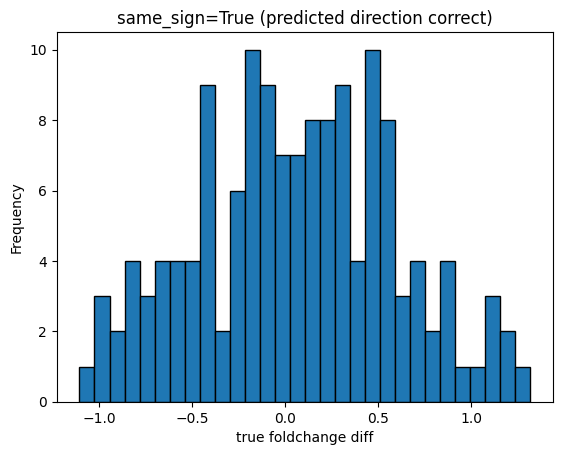

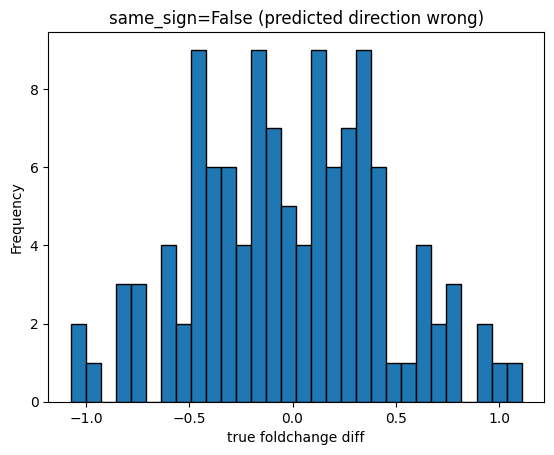

In [10]:
bigboss['same_sign'] = (bigboss['true'] * bigboss['avg_pred'] > 0)
bigboss_true = bigboss[bigboss['same_sign']]
plt.hist(bigboss_true['true'], bins=30, edgecolor='black')  # Adjust `bins` as needed
plt.xlabel('true foldchange diff')
plt.ylabel('Frequency')
plt.title('same_sign=True (predicted direction correct)')
plt.show()

bigboss['same_sign'] = (bigboss['true'] * bigboss['avg_pred'] < 0)
bigboss_true = bigboss[bigboss['same_sign']]
plt.hist(bigboss_true['true'], bins=30, edgecolor='black')  # Adjust `bins` as needed
plt.xlabel('true foldchange diff')
plt.ylabel('Frequency')
plt.title('same_sign=False (predicted direction wrong)')
plt.show()

# of same sign for true difference and predicted difference: 158 / 276 = 0.572463768115942 %
# of same sign for true difference and averaged predicted difference: 82 / 138.0 = 0.5942028985507246%
Pearson correlation coefficient: 0.1826, p-value: 0.002318
Spearman correlation coefficient: 0.1985, p-value: 0.0009159


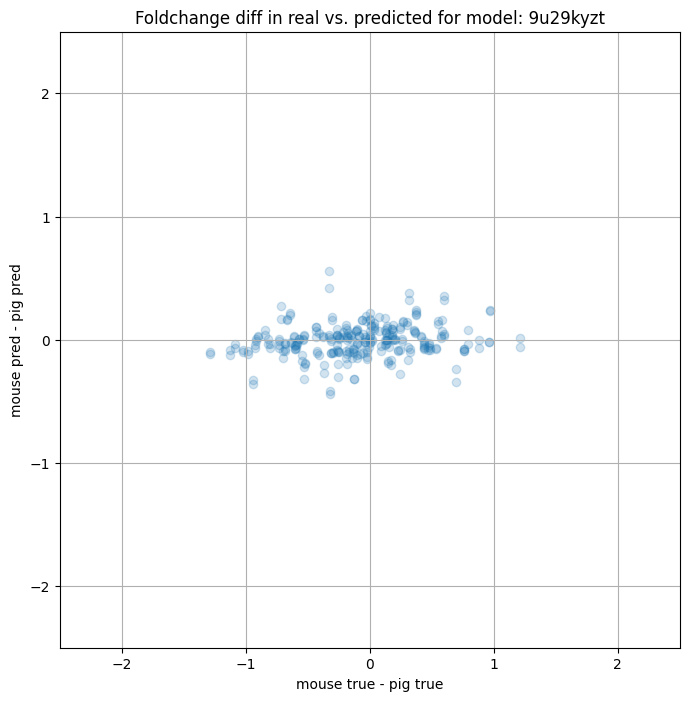

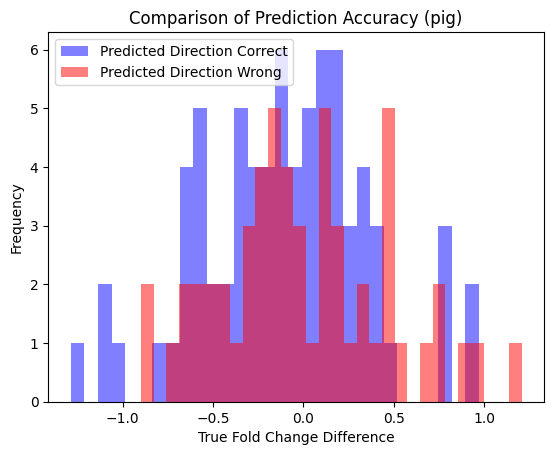

In [29]:
# POSITIVE ONLY FOLD CHANGE
species = 'pig'
model = '9u29kyzt'

mac_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/ladder_qn/{species}_liver_pos_ALL.bed', sep="\t", header=None)
mouse_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/ladder_qn/mouse_liver_pos_ALL.bed', sep="\t", header=None)

one_to_one_peaks = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/oneToOnePeaks/{species}_mouse.bed', header=None, sep='\t')
pred_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_{species}_VAL.csv', header=None)

val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val2/{species}_liver_VAL.narrowPeak', header=None, sep="\t").rename(columns={0: 'mac_chr'})

val2_len = 2*len(val2_df)

####################### make the ____ doubled predicted and true df
peaks = one_to_one_peaks[[4, 14]]

# merged_df = peaks.merge(mac_qn, how='left', left_on=4, right_on=3, suffixes=('', '_mac'))

# # Merge the result with df3 on col13 and df3['col3']
# merged_df = merged_df.merge(mouse_qn, how='left', left_on=14, right_on=3, suffixes=('_MAC', '_mouse'))

# # Subtract col4 values from df2 and df3
# # merged_df['result'] = merged_df['4_mac'] - merged_df['4_mouse']
# # res = merged_df[['4', 14, '4_mac', '4_mouse', 'result']]
# # nan = res[res.isna().any(axis=1)]

# # nan

####################### 

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.head(val2_len).reset_index(drop=True)

doubled_combined = pd.concat([doubled_val2_df, pred_val2_df], axis=1)

mac_val2_real_pred = doubled_combined.rename(columns={4: 'mac_true', 0:'mac_pred'})

merged_mac_real_pred = peaks.merge(mac_val2_real_pred, how='left', left_on=4, right_on=3).drop(14, axis=1)
# m_mac_pred = merged_mac_real_pred[~merged_mac_real_pred[3].isin(nan['3_mac'])].reset_index(drop=True)
m_mac_pred = merged_mac_real_pred.rename(columns={3:'mac_peak'}).drop(4, axis=1)


####################### make the mouse doubled predicted and true df

mouse_pred = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_mouse_VAL_TRAIN.csv', sep="\t", header=None)
mouse_real_pos=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/ladderPos/mouse_liver_VAL.narrowPeak', sep="\t", header=None)

real_pos_len = 2*len(mouse_real_pos)

mouse_pred_pos = mouse_pred.head(real_pos_len).reset_index(drop=True)

doubled_mouse_real_pos = pd.concat([mouse_real_pos, mouse_real_pos]).sort_index(kind='mergesort').reset_index(drop=True)


doubled_mouse_real_pos = doubled_mouse_real_pos.rename(columns={0:'mouse_chr'})
mouse_pos_real_pred = pd.concat([doubled_mouse_real_pos.drop(columns=5), mouse_pred_pos], axis=1)
mouse_pos_real_pred = mouse_pos_real_pred.rename(columns={4:'mouse_true', 0:'mouse_pred'}).reset_index(drop=True)


merged_mouse_pred = peaks.merge(mouse_pos_real_pred, how='left', left_on=14, right_on=3)

m_mouse_pred = merged_mouse_pred.rename(columns={3:'mouse_peak'}).drop([14], axis=1)

####################### make bigboss mouse + query predicted and real info

bigboss = pd.concat([m_mouse_pred, m_mac_pred], axis=1)
bigboss['true'] = bigboss['mouse_true']-bigboss['mac_true']
bigboss['pred'] = bigboss['mouse_pred']-bigboss['mac_pred']

mouse_av = (bigboss.loc[::2, 'mouse_pred'].values + bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (bigboss.loc[::2, 'mac_pred'].values + bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
bigboss['avg_pred'] = bigboss['mouse_pred_avg']-bigboss['mac_pred_avg']

same_sign = np.sign(bigboss['true']) == np.sign(bigboss['pred'])
print(f'# of same sign for true difference and predicted difference: {same_sign.sum()} / {len(bigboss)} = {same_sign.sum() / len(bigboss)} %')

same_sign = np.sign(bigboss.loc[::2]['true']) == np.sign(bigboss.loc[::2]['avg_pred'])
print(f'# of same sign for true difference and averaged predicted difference: {same_sign.sum()} / {len(bigboss) / 2} = {same_sign.sum() / (len(bigboss) / 2)}%')

x = bigboss['true']
y = bigboss['pred']

pearson_spearman(x, y)

plt.figure(figsize=(8, 8))
plt.axis([-2.5, 2.5, -2.5, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.xlabel(f'mouse true - {species} true')
plt.ylabel(f'mouse pred - {species} pred')
plt.title(f'Foldchange diff in real vs. predicted for model: {model}')
plt.grid(True)
plt.show()

bigboss['correct_mask'] = bigboss['true'] * bigboss['avg_pred'] > 0
incorrect_mask = bigboss['true'] * bigboss['avg_pred'] < 0

# Extract the values for each category
correct_values = bigboss.loc[correct_mask, 'true']
incorrect_values = bigboss.loc[incorrect_mask, 'true']

# Plot both histograms in one figure
plt.hist(correct_values, bins=30, alpha=0.5, color='blue', label='Predicted Direction Correct')
plt.hist(incorrect_values, bins=30, alpha=0.5, color='red', label='Predicted Direction Wrong')

# Labels and title
plt.xlabel('True Fold Change Difference')
plt.ylabel('Frequency')
plt.title(f'Comparison of Prediction Accuracy ({species})')
plt.legend()  # Show legend to distinguish colors

# Show the plot
plt.show()

In [28]:
incorrect_values

6      0.203933
8      0.040552
18     0.634592
20    -0.105903
24     0.667097
         ...   
780    0.168041
782    0.441028
784    0.051728
790    0.358463
794   -0.399062
Name: true, Length: 184, dtype: float64

In [139]:
mac_val2_real_pred

,mac_chr,1,2,3,mac_true,mac_pred
0,chr1,205023287,205023787,peak35668,2.217299,2.196859
1,chr1,205023287,205023787,peak35668,2.217299,2.259437
2,chr1,210767607,210768107,peak40056,2.354433,2.304870
3,chr1,210767607,210768107,peak40056,2.354433,2.317544
4,chr1,210790503,210791003,peak9815,3.063008,2.275088
...,...,...,...,...,...,...
657,chr8,43795452,43795952,peak46218,2.238436,2.305728
658,chr9,30516438,30516938,peak22968,2.954279,2.111576
659,chr9,30516438,30516938,peak22968,2.954279,2.139634
660,chr9,35000894,35001394,peak11504,3.142284,2.199708


In [138]:
pred_val2_df

,0
0,2.196859
1,2.259437
2,2.304870
3,2.317544
4,2.275088
...,...
657,2.305728
658,2.111576
659,2.139634
660,2.199708
